In [54]:
from pennylane import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
sys.path.insert(0, '/Users/tak/Github/QEmbedding/')
import Hybrid_nn
import torch
from torch import nn
import data
import pennylane as qml
import embedding

In [4]:
feature_reduction = 'PCA4'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', '2', feature_reduction=feature_reduction, classes=classes)

In [5]:
dev = qml.device('default.qubit', wires=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 4 qubit Model1_Fidelity
@qml.qnode(dev, interface="torch")
def Four_circuit(inputs): 
    embedding.Four_QuantumEmbedding(inputs[0:4])
    embedding.Four_QuantumEmbedding_inverse(inputs[4:8])
    return qml.probs(wires=range(4))

class Four_Model1_Fidelity(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer1 = qml.qnn.TorchLayer(Four_circuit, weight_shapes={})
        self.linear_relu_stack1 = nn.Sequential(
            nn.Linear(4, 5),
            nn.ReLU(),
            nn.Linear(5,5),
            nn.ReLU(),
            nn.Linear(5,4)
        )
    def forward(self, x1, x2):
        x1 = self.linear_relu_stack1(x1)
        x2 = self.linear_relu_stack1(x2)
        x = torch.concat([x1, x2], 1)
        x = self.qlayer1(x)
        return x[:,0]


In [6]:
def new_data(batch_size, X, Y):
    X1_new, X2_new, Y_new = [], [], []
    for i in range(batch_size):
        n, m = np.random.randint(len(X)), np.random.randint(len(X))
        X1_new.append(X[n])
        X2_new.append(X[m])
        if Y[n] == Y[m]:
            Y_new.append(1)
        else:
            Y_new.append(0)
    return torch.tensor(X1_new).to(device), torch.tensor(X2_new).to(device), torch.tensor(Y_new).to(device)

N_valid, N_test = 500, 10000
X1_new_valid, X2_new_valid, Y_new_valid = new_data(N_valid, X_test, Y_test)
X1_new_test, X2_new_test, Y_new_test = new_data(N_test, X_test, Y_test)

/opt/anaconda3/envs/QC/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646835196/work/torch/csrc/utils/tensor_new.cpp:233.)
  # This is added back by InteractiveShellApp.init_path()


In [8]:
def train_models():
    train_loss = []
    model = Four_Model1_Fidelity().to(device)
    model.train()

    loss_fn = torch.nn.MSELoss()
    opt = torch.optim.SGD(model.parameters(), lr=0.01)
    for it in range(500):
        X1_batch, X2_batch, Y_batch = new_data(25, X_train, Y_train)
        X1_batch, X2_batch, Y_batch = X1_batch.to(device), X2_batch.to(device), Y_batch.to(device)

        pred = model(X1_batch, X2_batch)
        pred, Y_batch = pred.to(torch.float32), Y_batch.to(torch.float32)
        loss = loss_fn(pred, Y_batch)
        train_loss.append(loss.item())

        opt.zero_grad()
        loss.backward()
        opt.step()

        if it % 10 == 0:
            print(f"Iterations: {it} Loss: {loss.item()}")
    
    PATH = '/Users/tak/Desktop/Four_Model.pt'
    torch.save(model.state_dict(), PATH)


train_models()

Iterations: 0 Loss: 0.2230391651391983
Iterations: 10 Loss: 0.25353625416755676
Iterations: 20 Loss: 0.3400680422782898
Iterations: 30 Loss: 0.2038978785276413
Iterations: 40 Loss: 0.1389174461364746
Iterations: 50 Loss: 0.12314468622207642
Iterations: 60 Loss: 0.1618308275938034
Iterations: 70 Loss: 0.16168513894081116
Iterations: 80 Loss: 0.07334420830011368
Iterations: 90 Loss: 0.07941792160272598
Iterations: 100 Loss: 0.05474209412932396
Iterations: 110 Loss: 0.04197293147444725
Iterations: 120 Loss: 0.06059898063540459
Iterations: 130 Loss: 0.05949533358216286
Iterations: 140 Loss: 0.10647403448820114
Iterations: 150 Loss: 0.029133658856153488
Iterations: 160 Loss: 0.050977058708667755
Iterations: 170 Loss: 0.05370132625102997
Iterations: 180 Loss: 0.011554013937711716
Iterations: 190 Loss: 0.03691698983311653
Iterations: 200 Loss: 0.027812447398900986
Iterations: 210 Loss: 0.038978204131126404
Iterations: 220 Loss: 0.06208603456616402
Iterations: 230 Loss: 0.0045116315595805645
I

In [66]:
feature_reduction = 'PCA4'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', '2', feature_reduction=feature_reduction, classes=classes)
X1_test, X0_test = [], []
for i in range(len(X_test)):
    if Y_test[i] == 1:
        X1_test.append(X_test[i])
    else:
        X0_test.append(X_test[i])
X1_test, X0_test = torch.tensor(X1_test), torch.tensor(X0_test)

dev3 = qml.device('default.qubit', wires=4)

@qml.qnode(dev3, interface="torch")
def Four_Distance(inputs): 
    embedding.Four_QuantumEmbedding(inputs[0:4])
    return qml.density_matrix(wires=range(4))

class DistanceModel1_Trace(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer1_distance = qml.qnn.TorchLayer(Four_Distance, weight_shapes={})
        self.linear_relu_stack1 = nn.Sequential(
            nn.Linear(4, 5),
            nn.ReLU(),
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5, 4)
        )
    def forward(self, x1, x0, Trained):
        if Trained:
            x1 = self.linear_relu_stack1(x1)
            x0 = self.linear_relu_stack1(x0)
        rhos1 = self.qlayer1_distance(x1)
        rhos0 = self.qlayer1_distance(x0)
        rho1 = torch.sum(rhos1, dim=0) / len(x1)
        rho0 = torch.sum(rhos0, dim=0) / len(x0)
        rho_diff = rho1 - rho0
        eigvals = torch.linalg.eigvals(rho_diff)
        return 0.5 * torch.real(torch.sum(torch.abs(eigvals)))

PATH = '/Users/tak/Desktop/Four_Model.pt'
Model = DistanceModel1_Trace()
Model.load_state_dict(torch.load(PATH, map_location='cpu'))

print(f"Trace Distance Before: {Model(X1_test, X0_test, False)}")
print(f"Trace Distance After: {Model(X1_test, X0_test, True)}")



/opt/anaconda3/envs/QC/lib/python3.7/site-packages/pennylane/qnn/torch.py:328: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646835196/work/aten/src/ATen/native/Copy.cpp:250.)
  return self.qnode(**kwargs).type(x.dtype)


Trace Distance Before: 0.2723434269428253
Trace Distance After: 0.9122326374053955


In [67]:
Lower_Bound_Before = 0.5 * (1 - 0.27234)
Lower_Bound_Afte = 0.5 * (1 - 0.91223)

## Training circuit with trained Qembedding

In [11]:
feature_reduction = 'PCA4'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', '2', feature_reduction=feature_reduction, classes=classes)
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]

In [45]:
class x_transform(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack1 = nn.Sequential(
            nn.Linear(4, 5),
            nn.ReLU(),
            nn.Linear(5,5),
            nn.ReLU(),
            nn.Linear(5,4)
        )
    def forward(self, x):
        x = self.linear_relu_stack1(x)
        return x.detach().numpy()

PATH = '/Users/tak/Desktop/Four_Model.pt'
model = x_transform()
model.load_state_dict(torch.load(PATH, map_location='cpu'))

<All keys matched successfully>

In [61]:
dev2 = qml.device("default.qubit", wires=4)

def statepreparation(x, Trained):
    if Trained:
        x = model(torch.tensor(x))
    embedding.Four_QuantumEmbedding(x)

@qml.qnode(dev2)
def circuit(weights, x, Trained):
    statepreparation(x, Trained)
    #qml.AngleEmbedding(x, wires=range(4))
    qml.StronglyEntanglingLayers(weights, wires=range(4))
    return qml.expval(qml.PauliZ(0))

def Linear_Loss(labels, predictions):
    loss = 0
    for l,p in zip(labels, predictions):
        loss += 0.5 * (1 - l * p)
    return loss / len(labels)

def MSE(labels, predictions):
    loss = 0
    for l,p in zip(labels, predictions):
        loss += (l - p) ** 2
    return loss /len(labels)

def cost(weights, X_batch, Y_batch, Trained):
    preds = [circuit(weights, x, Trained) for x in X_batch]
    return Linear_Loss(Y_batch, preds)

shape = qml.StronglyEntanglingLayers.shape(n_layers=1, n_wires=4)

steps = 1000
learning_rate = 0.01
batch_size = 25
def circuit_training(X_train, Y_train, Trained):

    weights = np.random.random(size=shape, requires_grad = True)
    opt = qml.NesterovMomentumOptimizer(stepsize=learning_rate)
    loss_history = []
    for it in range(steps):
        batch_index = np.random.randint(0, len(X_train), (batch_size,))
        X_batch = [X_train[i] for i in batch_index]
        Y_batch = [Y_train[i] for i in batch_index]
        weights, cost_new = opt.step_and_cost(lambda v: cost(v, X_batch, Y_batch, Trained),
                                                     weights)
        loss_history.append(cost_new)
        if it % 10 == 0:
            print("iteration: ", it, " cost: ", cost_new)
    return loss_history

In [64]:
loss_no_trained = circuit_training(X_train, Y_train, False)

iteration:  0  cost:  0.5423763869233484
iteration:  10  cost:  0.5020008007088717
iteration:  20  cost:  0.5124917008725172
iteration:  30  cost:  0.4813481713097784
iteration:  40  cost:  0.4942893333164686
iteration:  50  cost:  0.5062364005129455
iteration:  60  cost:  0.4950933190475385
iteration:  70  cost:  0.5259178215107764
iteration:  80  cost:  0.5124647179504553
iteration:  90  cost:  0.48516144162507474
iteration:  100  cost:  0.48984500919545143
iteration:  110  cost:  0.4983354727736193
iteration:  120  cost:  0.4676696069759345
iteration:  130  cost:  0.5080521232990298
iteration:  140  cost:  0.4950527950149698
iteration:  150  cost:  0.5433780578915799
iteration:  160  cost:  0.508106045764139
iteration:  170  cost:  0.501809343181217
iteration:  180  cost:  0.4938929168164157
iteration:  190  cost:  0.5012510566309012
iteration:  200  cost:  0.5409458147103924
iteration:  210  cost:  0.5016378457266665
iteration:  220  cost:  0.49918573800393273
iteration:  230  cost

In [63]:
loss_not_trained = circuit_training(X_train, Y_train, True)

iteration:  0  cost:  0.491245411349192
iteration:  10  cost:  0.49051322440770384
iteration:  20  cost:  0.49434620111137084
iteration:  30  cost:  0.49906425635907803
iteration:  40  cost:  0.48898104241259077
iteration:  50  cost:  0.4854791120194957
iteration:  60  cost:  0.5137894921500403
iteration:  70  cost:  0.4769140535221989
iteration:  80  cost:  0.46791226418173276
iteration:  90  cost:  0.46929758447135206
iteration:  100  cost:  0.4953619128468929
iteration:  110  cost:  0.4855418327594894
iteration:  120  cost:  0.48618331180866875
iteration:  130  cost:  0.4670980569150022
iteration:  140  cost:  0.457720216167679
iteration:  150  cost:  0.4802366942481145
iteration:  160  cost:  0.4789670340043511
iteration:  170  cost:  0.4668114350038418
iteration:  180  cost:  0.45514694773815395
iteration:  190  cost:  0.4644302330615686
iteration:  200  cost:  0.46028671706398794
iteration:  210  cost:  0.45068357204104936
iteration:  220  cost:  0.46467649168572367
iteration:  2

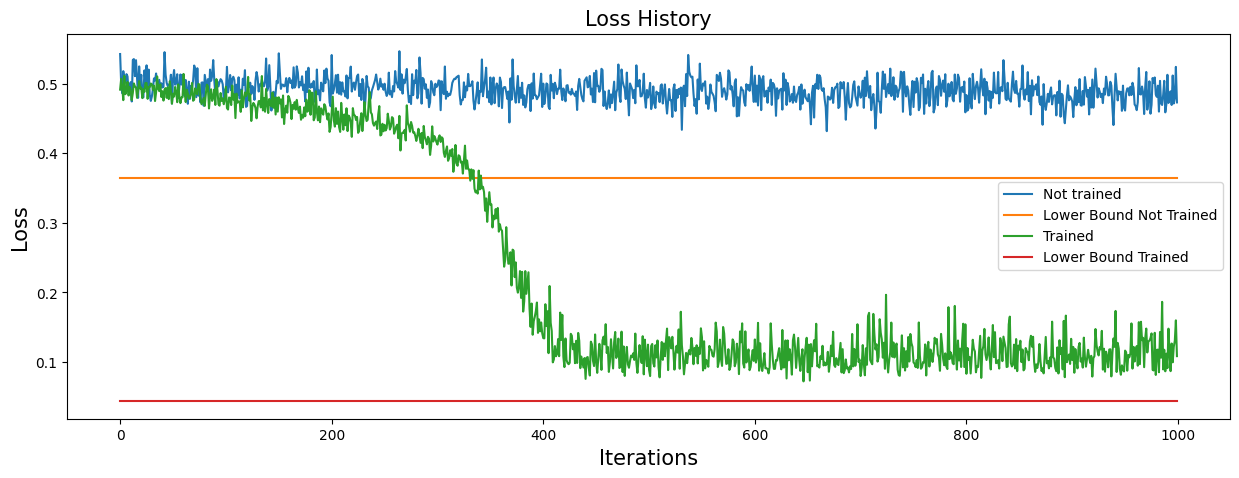

In [70]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax1 = plt.subplots()
ax1.plot(range(len(loss_no_trained)), loss_no_trained, label="Not trained")
ax1.plot(range(len(loss_no_trained)), np.ones(1000)*Lower_Bound_Before, label="Lower Bound Not Trained")
ax1.plot(range(len(loss_not_trained)), loss_not_trained, label="Trained")
ax1.plot(range(len(loss_no_trained)), np.ones(1000)*Lower_Bound_Afte, label="Lower Bound Trained")

ax1.set_title("Loss History").set_fontsize(15)
ax1.set_ylabel("Loss").set_fontsize(15)
ax1.set_xlabel("Iterations").set_fontsize(15)
ax1.legend()
